In [11]:
#load data for integrated brightnes (normalized, log-transformed data)
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import csv
import pickle

from sklearn import cross_validation
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import scipy.io
import scipy.stats


num_sample = 1000 # number of samples at each iteration

dataFile = open('integratedBrightness.p')
pre_integratedData = pickle.load(dataFile)
subsample = np.random.choice( len(pre_integratedData[1]) , num_sample, replace=False)
integratedData = []
for i in xrange(1, 25):
    for j in subsample:
	    integratedData.append(pre_integratedData[i][j])
integratedData = np.array(integratedData)
integratedData = np.reshape(integratedData, ( num_sample, 24))
visualize_threshold = scipy.io.loadmat(open('test123.mat'))
synapsin1 = np.array(visualize_threshold['p2'])[:,2]
synapsin2 = np.array(visualize_threshold['p1'])[:,2]

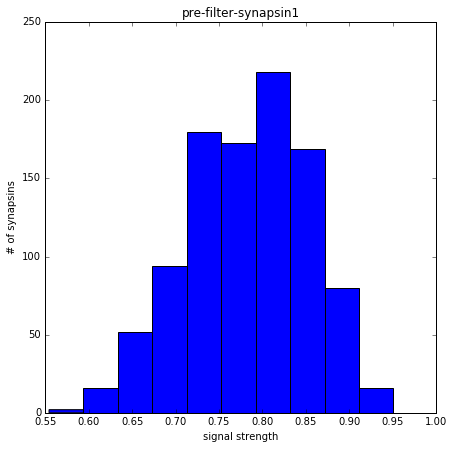

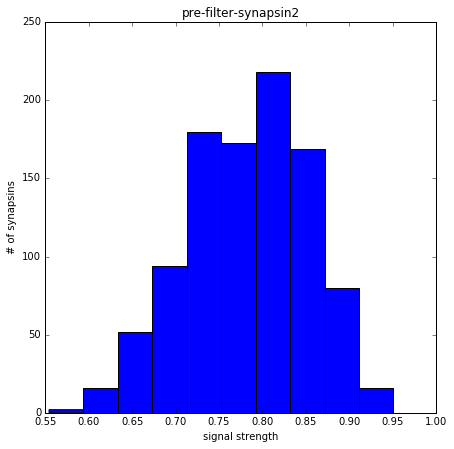

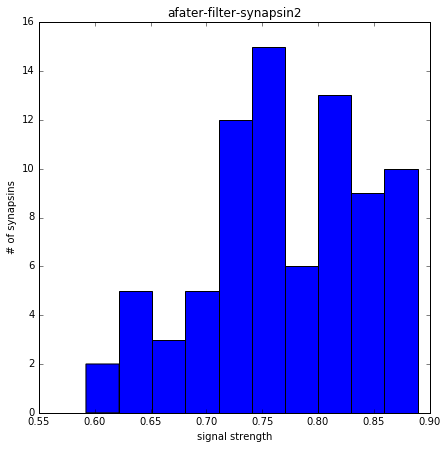

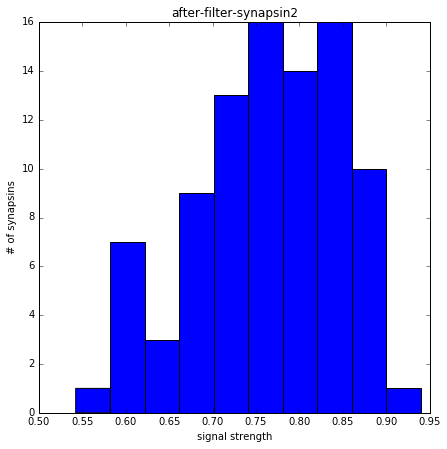

In [15]:
#plot the marginal for synapsin-1 and synapsin-2  before and after taking out some synapses using 
#using the labels produced by looking at each synapse position on the raw image (from matlab code)


plt.figure(figsize=(7,7))
pre_filter_synapsin1 = integratedData[:, 1];
plt.hist(pre_filter_synapsin1)
plt.title("pre-filter-synapsin1")
plt.xlabel("signal strength")
plt.ylabel("# of synapsins")
plt.show()

plt.figure(figsize=(7,7))
pre_filter_synapsin2 = integratedData[:, 2];
plt.hist(pre_filter_synapsin1)
plt.title("pre-filter-synapsin2")
plt.xlabel("signal strength")
plt.ylabel("# of synapsins")
plt.show()

synapsin1_sample = synapsin1[ np.array(subsample)]
after_synapsin1 = pre_filter_synapsin1[synapsin1_sample != 0];
plt.figure(figsize=(7,7))
plt.hist(after_synapsin1)
plt.title("afater-filter-synapsin2")
plt.xlabel("signal strength")
plt.ylabel("# of synapsins")
plt.show()

synapsin2_sample = synapsin2[ np.array(subsample)]
after_synapsin2 = pre_filter_synapsin2[synapsin2_sample != 0];
plt.figure(figsize=(7,7))
plt.hist(after_synapsin2)
plt.title("after-filter-synapsin2")
plt.xlabel("signal strength")
plt.ylabel("# of synapsins")
plt.show()

The filter that we used seems to take off data across singal strength without much of a bias. However, the distribution after the filter is applied became skewed to the left. This suggests that more data with weaker signal are taken out than that with stronger signal. We will try to go back to modify the metric we used to define each synapse on the raw image of the synapsin channels. But for now let us proceed to take out other irrelevant synapse entries based on other features. 

In [28]:
markers = ['Synap','Synap','VGlut1','VGlut1','VGlut2','Vglut3',
              'psd','glur2','nmdar1','nr2b','gad','VGAT',
              'PV','Gephyr','GABAR1','GABABR','CR1','5HT1A',
              'NOS','TH','VACht','Synapo','tubuli','DAPI']
synapType = ['synap','synap','ex.pre','ex.pre','ex.pre','in.pre',
                  'ex.post','ex.post','ex.post','ex.post','in.pre','in.pre',
                  'in.pre','in.post','in.post','in.post','other','other',
                  'other','other','other','other','none','none']




# filter away synapses so those with high tubulin and dapi expression will  be pruned away
sub_integratedData = integratedData[(synapsin1_sample != 0) & (synapsin2_sample != 0)]
avginttub = np.mean(sub_integratedData[:,22])
intfilteredtub = [synapse for synapse, value in enumerate(sub_integratedData[:,22]) if value < avginttub]

avgintdap = np.mean(sub_integratedData[:,23])
intfiltereddap = [synapse for synapse, value in enumerate(sub_integratedData[:,23]) if value < avgintdap]


FilteredInd = np.array(list(set(intfilteredtub).intersection(intfiltereddap)))
filteredInt = integratedData[FilteredInd]



We then proceeded to try to separate the resulting filtered synapses into two groups through a naive kMean method, after tranforming the synapse vector to a lower dimension.

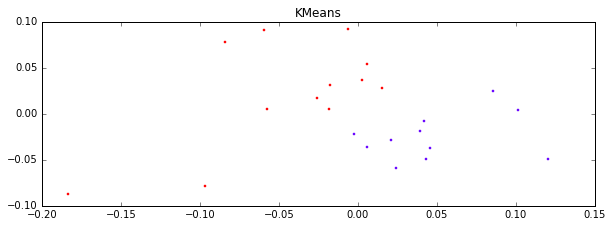

In [34]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
pca.fit(filteredInt)
filtered_trans = pca.transform(filteredInt)

from sklearn.cluster import KMeans
KM = KMeans(init='k-means++', n_clusters=2)
KM.fit(filtered_trans)
k_means_labels = KM.labels_
k_means_cluster_centers = KM.cluster_centers_
fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#FF0000', '#6600FF']

ax = fig.add_subplot(1, 1, 1)

for k, col in zip(range(2), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(filtered_trans[my_members, 0], filtered_trans[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    
ax.set_title('KMeans')


The above example uses all the features; let's remove dapi, tubuli, synapsins, and all the exhibitory/inhibitory synapse markers and repeat the clustering procedure.

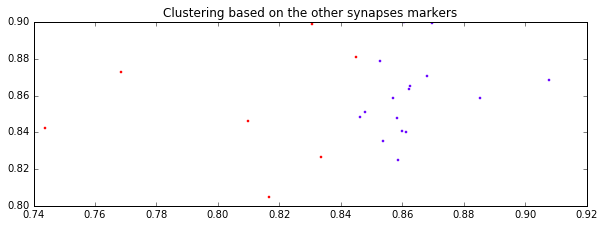

In [35]:
other = filteredInt[:, 15:21]
pca = decomposition.PCA(n_components=3)
pca.fit(other)
filtered_trans = pca.transform(other)

from sklearn.cluster import KMeans
KM = KMeans(init='k-means++', n_clusters=2)
KM.fit(other)
k_means_labels = KM.labels_
k_means_cluster_centers = KM.cluster_centers_
fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#FF0000', '#6600FF']

ax = fig.add_subplot(1, 1, 1)

for k, col in zip(range(2), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(other[my_members, 0], other[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    
ax.set_title('Clustering based on the other synapses markers')

We don't seem to be getting anywhere. I think it would be good to go back to the raw synapsin image again and think of a better metrics to filter the synapses. 